In [5]:
import sys
import logging
import matplotlib.pyplot as plt
import cstrees.cstree as ct
import cstrees.scoring as sc
import cstrees.stage as st
import cstrees.learning as ctl
import networkx as nx
import numpy as np
%load_ext autoreload
%autoreload 2
#logging.basicConfig(stream=sys.stderr, level=logging.DEBUG)
logging.basicConfig(stream=sys.stderr, level=logging.ERROR)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
from cstrees import csi_relation

ci = csi_relation.CI({1,2}, {3,4},{5})
print(ci)
dec = csi_relation.decomposition(ci)
for d in dec:
    print(d)

X1, X2 ⊥ X3, X4 | X5
X1 ⊥ X3 | X5
X1 ⊥ X4 | X5
X2 ⊥ X3 | X5
X2 ⊥ X4 | X5


In [7]:
wk = csi_relation.weak_union(ci)
for w in wk:
    print(w)

X1, X2 ⊥ X4 | X3, X5
X1, X2 ⊥ X3 | X4, X5
X2 ⊥ X3, X4 | X1, X5
X1 ⊥ X3, X4 | X2, X5


In [8]:
print("Original CI: ", ci)
pw = csi_relation.pairwise_cis(ci)
print("Pairwise CIs:")
for x in pw:
    print(x)

Original CI:  X1, X2 ⊥ X3, X4 | X5
Pairwise CIs:
X1 ⊥ X3 | X2, X4, X5
X1 ⊥ X4 | X2, X3, X5
X2 ⊥ X3 | X1, X4, X5
X2 ⊥ X4 | X1, X3, X5


In [9]:
c = csi_relation.Context({6:0})
csi = csi_relation.CSI(ci, c)

print("Original CSI: ", csi)
pw = csi_relation.pairwise_csis(csi)
print("Pairwise CSIs:")
for x in pw:
    print(x)

Original CSI:  X1, X2 ⊥ X3, X4 | X5, X6=0
Pairwise CSIs:
X1 ⊥ X3 | X2, X4, X5, X6=0
X1 ⊥ X4 | X2, X3, X5, X6=0
X2 ⊥ X3 | X1, X4, X5, X6=0
X2 ⊥ X4 | X1, X3, X5, X6=0


      a  b  c
0     2  2  2
1     1  0  1
2     1  0  0
3     1  0  0
4     0  0  0
...  .. .. ..
4996  1  0  0
4997  1  0  0
4998  0  0  0
4999  1  0  0
5000  1  0  0

[5001 rows x 3 columns]


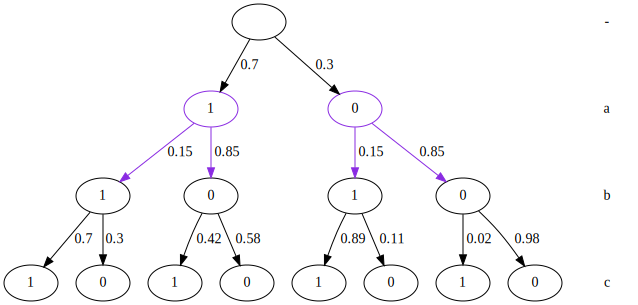

In [10]:
np.random.seed(6)
tree = ct.CStree([2] * 3, labels=["a", "b", "c"])

# V-structure
tree.update_stages({
    0: [st.Stage([{0, 1}])],
    1: [st.Stage([0, 0]), st.Stage([0, 1]), st.Stage([1, 0]), st.Stage([1, 1])]})

tree.sample_stage_parameters(alpha=1.0)

a = tree.plot()

# a.draw("testplot.png")
x = tree.sample(5000)
print(x)

true_cdags = tree.to_minimal_context_graphs()
for key, val in true_cdags.items():
    agraph = nx.nx_agraph.to_agraph(val)
    agraph.layout("dot")
    agraph.draw("testing/"+str(key) + "_true.png",
                args='-Glabel="'+str(key)+'"   ')
a


In [11]:

order = ["a", "b", "c"]
# Should order be expressed as the labels or as the levels?
# labels seems more natural but may include strings then which is a bit ugly.

# This is the order of the data columns.
s1 = sc.score_order(order, x, max_cvars=2, alpha_tot=1.0, method="BDeu")
print(s1)


-7767.510194306091


In [12]:
#order = [0, 2, 1]
order = ["a", "c", "b"]  # We know that b should not be to the very right.
s2 = sc.score_order(order, x, max_cvars=2, alpha_tot=1.0, method="BDeu")
print(s2)


-7771.847348603729


In [13]:
#order = [0, 2, 1]
import random
np.random.seed(1)
random.seed(1)
tree = ct.sample_cstree([2,2,2,2], max_cvars=1, prob_cvar=0.5, prop_nonsingleton=1)
tree.to_df()

,0,1,2,3
0,2,2,2,2
1,*,-,-,-
2,*,1,-,-
3,*,0,-,-
4,0,*,*,-
5,1,*,*,-


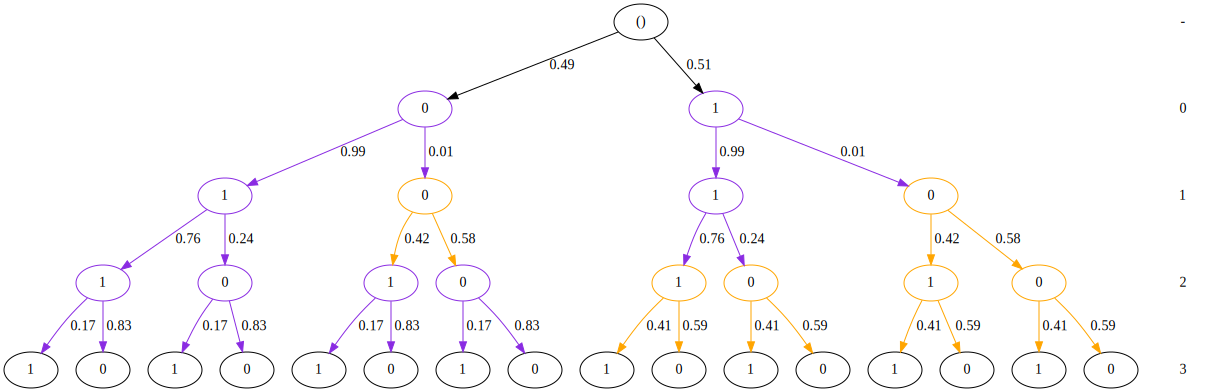

In [23]:
tree.plot()

In [22]:
tree.sample_stage_parameters(alpha=1.0)
df = tree.sample(1000)

counts = sc.counts_at_level(tree, 2, df)

for key, val in counts.items():
    print("Stage: {}".format(key))
    print("Counts: {}".format(val))

Stage: [{0, 1}, 1]; probs: [0.24134031 0.75865969]; color: blueviolet
Counts: {1: 756, 0: 241}
Stage: [{0, 1}, 0]; probs: [0.58026003 0.41973997]; color: orange
Counts: {0: 3}


In [24]:
sc.score_level(tree, 2, counts, alpha_tot=1.0, method="BDeu")

-556.4949720501456

In [35]:
stage = tree.stages[1][0]
print(stage)
param_est = sc.estimate_parameters(tree, stage, counts, alpha_tot=1.0, method="BDeu")
print(param_est)

[{0, 1}, 1]; probs: [0.24134031 0.75865969]; color: blueviolet
[0.24185463659147868, 0.7581453634085213]


In [36]:
sc.score(tree, df, alpha_tot=1.0, method="BDeu")

-1829.2311869978726

In [14]:
optord, score = ctl._find_optimal_order(
    x, strategy="max", max_cvars=2, alpha_tot=1.0, method="BDeu")
print("optimal order: {}, score {}".format(optord, score))

opttree = ctl._optimal_cstree_given_order(optord, x, max_cvars=2,
                             alpha_tot=1.0, method="BDeu")
print("stages :{}".format(opttree.stages))

print("\nOptimal CStree stagings per level:")
for key, val in opttree.stages.items():
    if key == -1:
        continue
    print("level {}:".format(key))
    for val2 in val:
        print(val2)
opttree.estimate_stage_parameters(x, alpha_tot=1.0, method="BDeu")
opttree.plot()


AttributeError: module 'cstrees.scoring' has no attribute 'score_order'

In [ ]:
opt_cdags = opttree.to_minimal_context_graphs()
for key, val in opt_cdags.items():
    agraph = nx.nx_agraph.to_agraph(val)
    agraph.layout("dot")
    agraph.draw("testing/"+str(key) + "_opt.png",
                args='-Glabel="'+str(key)+'"   ')


In [ ]:
tree = ctl.find_optimal_cstree(x, max_cvars=2, alpha_tot=1.0, method="BDeu")

tree.to_df()


,a,b,c
0,2,2,2
1,*,-,-
2,0,0,-
3,1,0,-
4,0,1,-
5,1,1,-
